# COMP47670 Assignment II Autumn 2023
## Time Series Running Data

## Objective
The objective of this assignment is to identify good models for classifying time series data.  
The data is from an accelerometer sensor and there are samples of fatigued and non-fatigued running. The data has been segmented into strides and the segments (samples) are labelled F (fatigued) and NF (not fatigued). The data for two subjects A and B are available in the files  `fatigueA.csv` and  `fatigueB.csv`. This dataset is extracted from a much larger dataset described [here](https://openreview.net/pdf?id=9c0lAonDNP).  
At present, the best performing method for time-series classification is [Rocket](https://openreview.net/pdf?id=9c0lAonDNP). 
A rocket implementation is available in the [sktime tool kit](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.rocket.Rocket.html). This sktime implementation can be used in this assignment.   
Some code to get you started in available in the notebook `RunningCore`.



In [1]:
# pip install sktime

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [7]:
fatigue_df = pd.read_csv('fatigueA.csv', header = None) # sep = '\s+')
print(fatigue_df.shape)
fatigue_df

(421, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,F,2.72,2.69,2.750,2.890,3.07,3.27,3.48,3.67,3.82,...,6.50,6.16,5.75,5.29,4.79,4.29,3.83,3.42,3.09,2.85
1,F,2.68,2.47,2.460,2.540,2.69,2.93,3.36,3.99,4.75,...,2.79,3.88,5.18,6.29,6.88,6.80,6.13,5.11,4.04,3.20
2,F,5.04,5.69,6.210,6.520,6.59,6.47,6.26,6.06,5.91,...,5.89,5.29,4.72,4.20,3.77,3.47,3.36,3.47,3.82,4.38
3,F,2.42,3.21,4.020,4.580,4.77,4.64,4.39,4.25,4.42,...,8.60,8.76,8.76,8.32,7.34,5.91,4.33,2.97,2.14,1.98
4,F,3.35,3.40,3.890,4.710,5.66,6.47,6.90,6.81,6.25,...,9.45,8.52,7.75,7.14,6.63,6.15,5.60,4.96,4.28,3.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,NF,2.37,3.17,3.810,4.180,4.32,4.42,4.68,5.27,6.17,...,6.41,6.24,5.91,5.26,4.27,3.11,2.07,1.39,1.26,1.64
417,NF,2.42,1.86,1.910,2.640,3.84,5.11,6.02,6.29,5.93,...,7.45,5.94,4.63,3.85,3.68,3.96,4.32,4.41,4.04,3.28
418,NF,2.17,1.45,1.850,3.430,5.69,7.76,8.86,8.69,7.60,...,8.58,8.57,7.83,6.84,6.08,5.75,5.69,5.46,4.73,3.49
419,NF,2.07,1.16,0.671,0.737,1.37,2.46,3.84,5.33,6.78,...,8.02,7.08,6.45,6.14,6.04,5.96,5.71,5.16,4.29,3.19


Text(0, 0.5, 'Accel Mag')

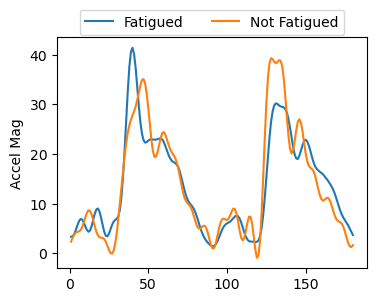

In [3]:
fatigue_df.iloc[4][1:].plot(label='Fatigued')
fatigue_df.iloc[-5][1:].plot(figsize=(4,3), label = 'Not Fatigued')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)
plt.ylabel('Accel Mag')


In [4]:
y = fatigue_df.pop(0).values
X = fatigue_df.values

### Task 1
Calculate the accuracy of a logistic regression classifier (`SGDClassifier`) on the raw time series data for subject A. 

In [5]:
X.shape, y.shape

((421, 180), (421,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
clf = SGDClassifier(max_iter=10000)
clf.fit(X_train, y_train)

cv_scores = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')
print("Cross-validation accuracy:", round(cv_scores.mean(), 4))

y_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", round(test_accuracy, 4))

Cross-validation accuracy: 0.7393
Test accuracy: 0.8582


### Task 2
The RunningCore Notebook contains code to convert the data to the `sktime` time-series format. Using this format assess the accuracy of the Rocket transformer coupled with an `SGDClassifier` classifier on the data for subject A. 


In [14]:
X3d = X[:,np.newaxis,:] # time series algs require a 3D data array (sample, var, tick)
X3d.shape

(421, 1, 180)